<a href="https://colab.research.google.com/github/Mgonzal3z/Computer-Vision/blob/main/Computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 0: Mount Google Drive

## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

## Download and explore the dataset

In [ ]:
import pathlib

PATH = '/content/Tienda'

data_dir = os.path.join(PATH,"train")
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')) + list(data_dir.glob('*/*.JPG'))  + list(data_dir.glob('*/*.png'))  + list(data_dir.glob('*/*.PNG')) + list(data_dir.glob('*/*.jfif')) + list(data_dir.glob('*/*.JFIF')))
print("TOTAL IMAGES: ", image_count)

TOTAL IMAGES:  234


## Create a dataset

In [ ]:
#Setup basic parameters
batch_size = 16
img_height = 400
img_width = 400

#Setup training dataset
print("TRAINING DATASET:")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#Setup testing dataset
print("\nTESTING DATASET:")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print("\nCLASS NAMES:")
class_names = train_ds.class_names
print(class_names)

TRAINING DATASET:
Found 197 files belonging to 5 classes.
Using 178 files for training.

TESTING DATASET:
Found 197 files belonging to 5 classes.
Using 19 files for validation.

CLASS NAMES:
['Camisas', 'Jugo_Naranja', 'Manzanas', 'Pantalones', 'Papas']


## Visualize the data

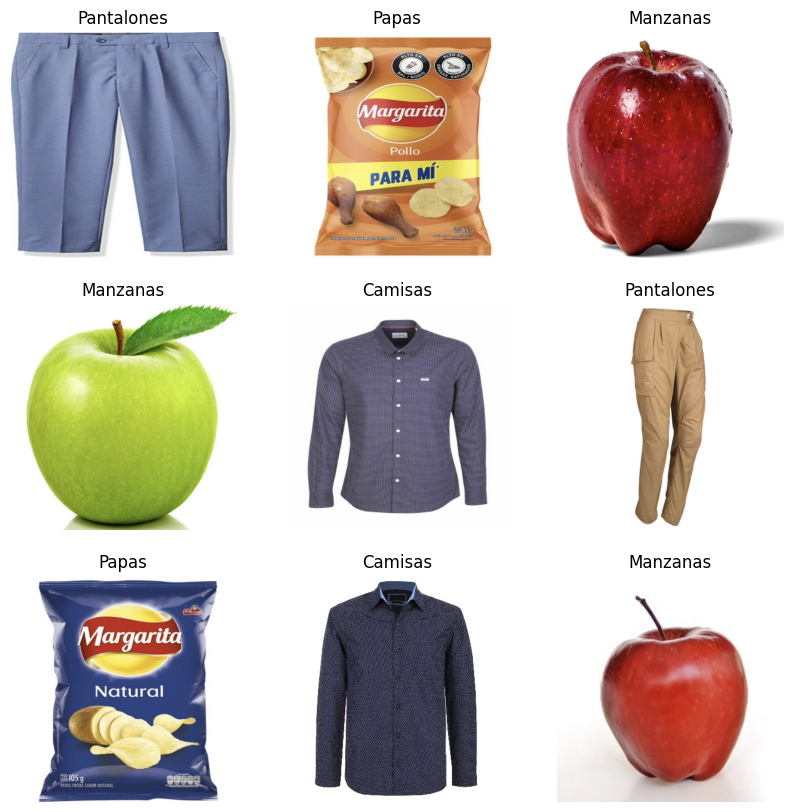

In [ ]:
#Here are the first 9 images from the training dataset.

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#Size of batch for training images
for image_batch, labels_batch in train_ds:
  print("IMAGE BATCH SHAPE: ", image_batch.shape)
  print("LABELS BATCH SHAPE: ", labels_batch.shape)
  break

IMAGE BATCH SHAPE:  (16, 400, 400, 3)
LABELS BATCH SHAPE:  (16,)


## Configure the dataset for performance


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


## Setup a Model

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("vertical", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

num_classes = 5

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model



In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary


## Train the model

In [ ]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, shuffle=True
)

Epoch 1/50
12/12 [==============================] - 12s 450ms/step - loss: 3.2620 - accuracy: 0.3090 - val_loss: 1.5344 - val_accuracy: 0.3684
Epoch 2/50
12/12 [==============================] - 1s 109ms/step - loss: 1.3101 - accuracy: 0.4944 - val_loss: 1.3130 - val_accuracy: 0.4211
Epoch 3/50
12/12 [==============================] - 1s 96ms/step - loss: 0.9557 - accuracy: 0.6348 - val_loss: 0.9756 - val_accuracy: 0.6316
Epoch 4/50
12/12 [==============================] - 1s 96ms/step - loss: 0.7596 - accuracy: 0.6629 - val_loss: 0.8726 - val_accuracy: 0.7368
Epoch 5/50
12/12 [==============================] - 1s 100ms/step - loss: 0.6374 - accuracy: 0.7247 - val_loss: 0.9668 - val_accuracy: 0.5789
Epoch 6/50
12/12 [==============================] - 1s 99ms/step - loss: 0.8471 - accuracy: 0.6685 - val_loss: 0.5089 - val_accuracy: 0.8421
Epoch 7/50
12/12 [==============================] - 1s 96ms/step - loss: 0.5294 - accuracy: 0.8034 - val_loss: 0.4066 - val_accuracy: 0.8947
Epoch 8/5

## Visualize training results

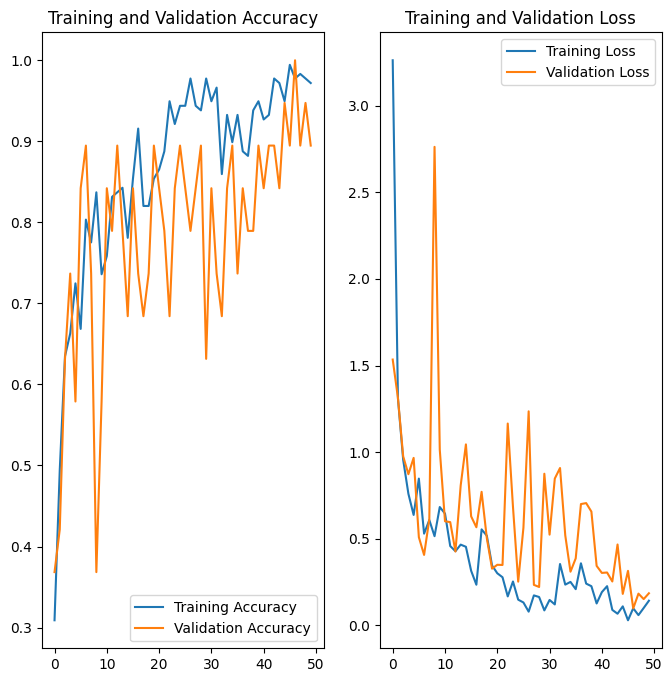

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [ ]:
url = "file:/content/Tienda/test/Papas.png"
path = tf.keras.utils.get_file('Papas', origin=url)

img = keras.preprocessing.image.load_img(
    path, target_size=(img_height, img_width)
)
img_array= keras.preprocessing.image.img_to_array(img)
img_array= tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(str(class_names))
print(str(predictions))

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 1s 914ms/step
['Camisas', 'Jugo_Naranja', 'Manzanas', 'Pantalones', 'Papas']
[[-7.101053   3.8738203 -5.6590867 -1.4229602 15.595791 ]]
This image most likely belongs to Papas with a 100.00 percent confidence.


## Save Model

In [ ]:
tf.keras.models.save_model(model, '/content/model_saved/')

## Camera Capture


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.keras.models.save_model(model, '/content/drive/MyDrive/model_saved/')

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photoObject.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capturar Objeto';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photoObject.jpg


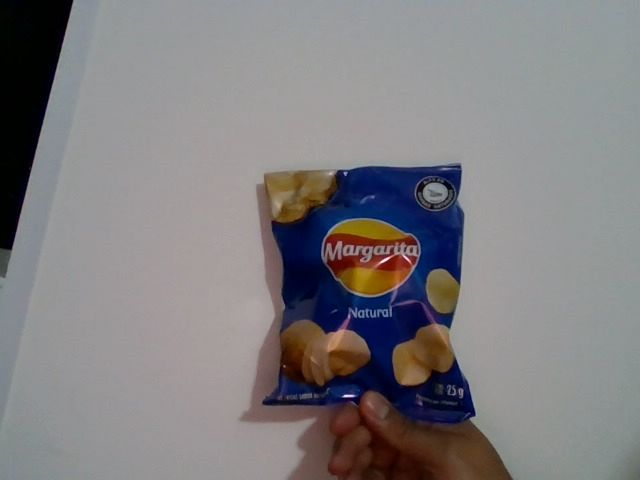

1/1 [==============================] - 0s 19ms/step
['Camisa', 'Jugo', 'Manzana', 'Pantalon', 'Papas']
[[-1.2706403  3.9931235  2.713562   3.827      7.9571257]]

------------------
------------------
 El objeto capturado es Papas con un 96.11 de probabilidad.
------------------
 ------------------


In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
  img = keras.preprocessing.image.load_img(
      filename, target_size=(img_height, img_width)
  )
  img_array= keras.preprocessing.image.img_to_array(img)
  img_array= tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(str(class_names))
  print(str(predictions))

  print(
      "\n------------------\n------------------\n El objeto capturado es {} con un {:.2f} de probabilidad.\n------------------\n ------------------"
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )

except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/model_saved')

# Check its architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 400, 400, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 400, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 400, 400, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 200, 200, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 100, 100, 64)      0         
 g2D)                                                 

In [ ]:
!pip install transformers
!pip install twilio requests
!pip install Flask==3.0.0 pyngrok==7.1.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: blinker
    Found existing installation: blinker 1.4
ERROR: Cannot uninstall 'blinker'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [ ]:
ngrok_key = "2ch8jgSQ1tKTqo5n0GS8FrvY23f_2AedfToU8bLnPPdGo4NTW"
#ngrok_key = "YOUR_NGROK_AUTHTOKEN"
port= 5000

In [ ]:
#Requiered for object-detection. It requieres restart runtime.
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 86.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [ ]:
from pyngrok import ngrok

ngrok.set_auth_token(ngrok_key)
ngrok.connect(port).public_url

'https://6c6a-35-204-161-84.ngrok-free.app'

In [ ]:
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

from skimage import io

In [ ]:
import os
import requests
from PIL import Image
from flask import Flask, request
from twilio.twiml.messaging_response import MessagingResponse
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DOWNLOAD_DIRECTORY = '/content/TemporaryImages/'

In [ ]:
app = Flask(__name__)

@app.route('/bot', methods=['POST'])
def bot():

    resp = MessagingResponse()
    if request.values['NumMedia'] != '0':
       # try:
            # Obtener la URL de la imagen enviada por el bot
           # Use the message SID as a filename.
            filename = request.values['MessageSid']+'.jpg'
            filepath = subdir = os.path.join(DOWNLOAD_DIRECTORY, filename)

            with open(filepath, 'wb') as f:
                image_url = request.values['MediaUrl0']
                f.write(requests.get(image_url).content)
           # if response.status_code == 200:

              # Redimensionar la imagen al tamaño esperado por el modelo
            img = keras.preprocessing.image.load_img(
                filepath, target_size=(img_height, img_width)
            )
            img_array= keras.preprocessing.image.img_to_array(img)
            img_array= tf.expand_dims(img_array, 0) # Create a batch

            predictions = model.predict(img_array)
            score = tf.nn.softmax(predictions[0])

            print(str(class_names))
            print(str(predictions))
            if class_names[np.argmax(score)] == "Manzanas":
              resp.message("Esta imagen pertenece en su mayoría a {} con un {:.2f} porcentaje de confianza. " \
                        "Se tienen 20 Manzanas en stock. " \
                        "https://www.exito.com/mercado/frutas-y-verduras".format(class_names[np.argmax(score)], 100 * np.max(score)))
            elif class_names[np.argmax(score)] == "Camisas":
                resp.message("Esta imagen pertenece en su mayoría a {} con un {:.2f} porcentaje de confianza. " \
                          "Se tienen 12 Camisas en stock. " \
                          "https://co.hm.com/hombre/camisetas".format(class_names[np.argmax(score)], 100 * np.max(score)))
            elif class_names[np.argmax(score)] == "Pantalones":
                resp.message("Esta imagen pertenece en su mayoría a {} con un {:.2f} porcentaje de confianza. " \
                          "Se tienen 26 Pantalones en stock. " \
                          "https://co.hm.com/hombre/pantalones".format(class_names[np.argmax(score)], 100 * np.max(score)))
            elif class_names[np.argmax(score)] == "Papas":
                resp.message("Esta imagen pertenece en su mayoría a {} con un {:.2f} porcentaje de confianza. " \
                          "Se tienen 32 Papas en stock. " \
                          "https://www.exito.com/uefamargarita".format(class_names[np.argmax(score)], 100 * np.max(score)))
            elif class_names[np.argmax(score)] == "Jugo_Naranja":
               resp.message("Esta imagen pertenece en su mayoría a {} con un {:.2f} porcentaje de confianza. " \
                          "Se tienen 9 Jugos de naranja en stock. " \
                          "https://www.exito.com/mercado/bebidas".format(class_names[np.argmax(score)], 100 * np.max(score)))
            else:
                 resp.message("Esta imagen pertenece en su mayoría a {} con un {:.2f} porcentaje de confianza.".format(class_names[np.argmax(score)], 100 * np.max(score)))

            print(
                "This image most likely belongs to {} with a {:.2f} percent confidence."
                .format(class_names[np.argmax(score)], 100 * np.max(score))
            )
           # else:
            #  print("Error al descargar la imagen. Código de estado:", response.status_code)

       # except Exception as e:
            # En caso de error, enviar un mensaje de error
           # resp.message("Ocurrió un error al procesar la imagen.")

    else:
        # Si no se envió ninguna imagen, solicitar al usuario que envíe una
        resp.message("Hola 👋🏼, envía una imagen para analizarla.")

    return str(resp)

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


1/1 [==============================] - 0s 19ms/step


INFO:werkzeug:127.0.0.1 - - [04/Apr/2024 21:22:41] "POST /bot HTTP/1.1" 200 -


['Camisas', 'Jugo_Naranja', 'Manzanas', 'Pantalones', 'Papas']
[[ 8.345616    1.288166   -5.7622714  -0.29195327  9.708512  ]]
This image most likely belongs to Papas with a 79.61 percent confidence.
1/1 [==============================] - 0s 20ms/step


INFO:werkzeug:127.0.0.1 - - [04/Apr/2024 21:30:34] "POST /bot HTTP/1.1" 200 -


['Camisas', 'Jugo_Naranja', 'Manzanas', 'Pantalones', 'Papas']
[[ 18.680588    1.623752  -10.632466    2.1439373  -0.4062712]]
This image most likely belongs to Camisas with a 100.00 percent confidence.
